In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json

In [ ]:
import numpy as np
import pandas as pd
from numpy import mean
from scipy import stats

In [ ]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [ ]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [ ]:
from flask import Flask, jsonify

In [ ]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [18]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [19]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [20]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [21]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [13]:
#Tutor showed me a way to do the coding I did below in a different way
last_year = session.query(func.max(Measurement.date)).all()

#dt.timedelta(days=365)
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_ago

datetime.date(2016, 8, 23)

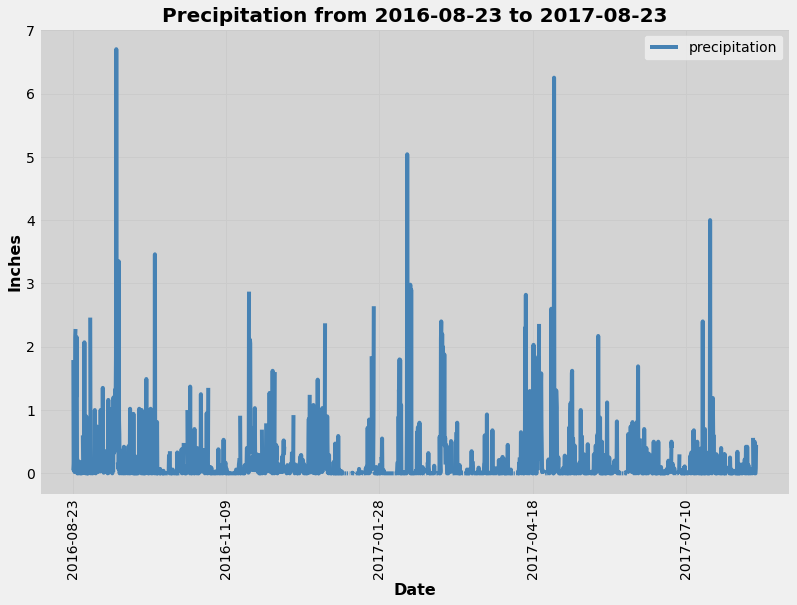

In [76]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_query_date = last_query[0]
last_date = dt.datetime.strptime(last_query_date, '%Y-%m-%d').date()


# Calculate the date 1 year ago from the last data point in the database
year_ago = last_date - dt.timedelta(days=365)
year_ago_date = year_ago.strftime('%Y-%m-%d')


# Perform a query to retrieve the data and precipitation scores
precip_score = session.query(Measurement.date, Measurement.prcp)\
                        .filter(Measurement.date <= last_date)\
                        .filter(Measurement.date >= year_ago_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
year_precip_df = pd.DataFrame(precip_score, columns=['date', 'precipitation']).set_index('date')

# Sort the dataframe by date
sort_year_precip_df = year_precip_df.sort_index()

sort_year_precip_df

# Use Pandas Plotting with Matplotlib to plot the data
prcp_year = sort_year_precip_df.plot(kind='line', rot=90, figsize=(12,8), grid=True, use_index=True, color='steelblue')
plt.title(f'Precipitation from {year_ago_date} to {last_date}', fontweight ='bold', size=20)
plt.xlabel('Date', fontweight ='bold', size=16)
plt.ylabel('Inches', fontweight ='bold', size=16)
plt.xticks()
prcp_year.set_facecolor('lightgray')
prcp_year.figure.savefig('Images/year_prcp_bar.png')
plt.show()

# Exploratory Climate Analysis

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_summary = year_precip_df.describe()
prcp_summary

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
num_station = session.query(Measurement.station).distinct().count()
print(f"There are {num_station} stations available in this dataset.")

There are 9 stations available in this dataset.


In [27]:
# What are the most active stations? (i.e. what stations have the most rows)?
most_act_stations = session.query(Measurement.station, Station.name, func.count(Measurement.station))\
                    .group_by(Measurement.station)\
                    .order_by(func.count(Measurement.station).desc())\
                    .first()

print(f"The most active station is station: {most_act_stations}.")

The most active station is station: ('USC00519281', 'WAIKIKI 717.2, HI US', 24948).


In [35]:
# List the stations and the counts in descending order.

h = session.query(Measurement.station, Station.name, func.count(Measurement.station)).group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).all()
                                 
active_stations

active_stations_df = pd.DataFrame(active_stations, columns=['Station ID', 'Station Name', 'Pieces of Data'])

active_stations_df

,Station ID,Station Name,Pieces of Data
0,USC00519281,"WAIKIKI 717.2, HI US",24948
1,USC00519397,"WAIKIKI 717.2, HI US",24516
2,USC00513117,"WAIKIKI 717.2, HI US",24381
3,USC00519523,"WAIKIKI 717.2, HI US",24021
4,USC00516128,"WAIKIKI 717.2, HI US",23508
5,USC00514830,"WAIKIKI 717.2, HI US",19818
6,USC00511918,"WAIKIKI 717.2, HI US",17811
7,USC00517948,"WAIKIKI 717.2, HI US",12348
8,USC00518838,"WAIKIKI 717.2, HI US",4599


In [41]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
summ_stations = session.query(Measurement.station, Station.name, func.min(Measurement.tobs), 
                                func.max(Measurement.tobs), func.avg(Measurement.tobs))\
                                .filter(Measurement.station == Station.station)\
                                .group_by(Measurement.station)\
                                .order_by(func.count(Measurement.station).desc())\
                                .filter(Measurement.station == most_act_stations[0])


summ_stations_df = pd.DataFrame(summ_stations, columns=["Station ID", "Station Name", "Min Temp", "Max Temp", "Avg Temp"])

summ_stations_df

,Station ID,Station Name,Min Temp,Max Temp,Avg Temp
0,USC00519281,"WAIHEE 837.5, HI US",54.0,85.0,71.663781


In [46]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

high_station = session.query(Measurement.tobs)\
                    .filter(Measurement.date <= last_date)\
                    .filter(Measurement.date >= year_ago_date)\
                    .filter(Measurement.station == most_act_stations[0])\
                    .all()

high_station_df = pd.DataFrame(high_station, columns =['tobs'])
high_station_df

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


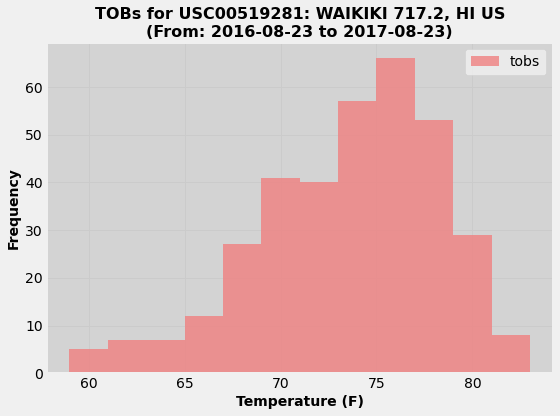

In [77]:
high_station_year = high_station_df.plot.hist(bins=12, figsize=(8,6), color='lightcoral', alpha=0.8)
plt.title(f'TOBs for {most_act_stations[0]}: {most_act_stations[1]}\n(From: {year_ago_date} to {last_date})', fontweight = 'bold', size=16)
plt.xlabel('Temperature (F)', fontweight = 'bold', size=14)
plt.ylabel('Frequency',fontweight = 'bold', size=14)
high_station_year.set_facecolor('lightgray')
plt.tight_layout()
high_station_year.figure.savefig('Images/USC00519281_histogram.png')
plt.show()